In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from typing import Tuple
from scipy.stats import t
from flight_delay_utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80 !important; }</style>"))

## Setup Simulation

In [27]:
df = pd.read_csv("../T_ONTIME_REPORTING.csv")

In [29]:
destinations = df.DEST.unique()
origins = df.ORIGIN.unique()


mean_arr, std_arr = get_delays(df, destinations, origins)
mean_dep, _ = get_delays(df, destinations, origins, delay_type="DEP_DELAY")
mean_flight = mean_dep-mean_arr
std_delay_diff = get_delay_statistics(df, destinations, origins)
sample_size = df.groupby(['ORIGIN', 'DEST']).size().unstack(fill_value=0)

In [31]:
tail_numbers = df.TAIL_NUM.unique()
keys = ["DEST", "ORIGIN", "ARR_TIME", "DAY_OF_MONTH"]

airport_names = df.DEST.unique()
airport_data = {}
for name in airport_names:
    airport_data[name] = []

for i, number in enumerate(tail_numbers):
    all_flights = df[df.loc[:, "TAIL_NUM"] == number]
    old_flight = pd.Series({"DEST": [np.NaN, np.NaN]})
    for month in all_flights.MONTH.unique():
        month_flights = all_flights[all_flights.loc[:, "MONTH"] == month]
        for day in month_flights.DAY_OF_MONTH.unique():
            flights = month_flights[month_flights.loc[:, "DAY_OF_MONTH"] == day]
            flights = flights.sort_values(by="ARR_TIME")
            for _, flight in flights.iterrows():
                if old_flight.DEST == flight.ORIGIN:
                    airport_data[flight.ORIGIN].append(flight.DEP_DELAY - flight.ARR_DELAY)
                old_flight = flight

5413


In [32]:



# Create a new DataFrame to store the sampled values
flights_df = mean_flight.copy()
first_df = mean_flight.copy()


# Apply the sampling function to each element
for origin in flights_df.index:
    for dest in flights_df.columns:
        mean = mean_flight.at[dest, origin]
        std = std_delay_diff.at[dest, origin]
        n = sample_size.at[dest, origin]
        flights_df.at[dest, origin] = lambda size, mean=mean, std=std, n=n : t.rvs(n-1, mean, std, size=size)
        
        mean = mean_arr.at[dest, origin]
        std = std_arr.at[dest, origin]
        first_df.at[dest, origin] = lambda size, mean=mean, std=std, n=n : t.rvs(n-1, mean, std, size=size)

In [34]:
ground = []
for airport in airport_data.keys():
    ground.extend(airport_data[airport])
arr = np.array(ground)
ground_mean = np.mean(arr[~np.isnan(arr)])


means = {}
std = {}
functions = {}
for airport in airport_data.keys():
    arr = np.array(airport_data[airport])
    clean_arr = arr[~np.isnan(arr)]
    if clean_arr.size > 0 :
        _, p_value = ttest_1samp(clean_arr, ground_mean)
        if p_value < 0.05:
            means[airport] = np.mean(clean_arr)
        else:
            means[airport] = ground_mean
        std[airport] = np.std(clean_arr)
        df, loc, scale = t.fit(clean_arr)
        functions[airport]  = lambda size: t.rvs(df, loc, scale, size=size) 
        # print(f"Airport = {airport}, delay = {functions[airport](1)}")
    else:
        means[airport] = ground_mean


## Find which airports add the most/least time to a flights

/var/folders/b2/z2q2350912181z4lh8p9jrc40000gn/T/ipykernel_26406/2107109985.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(top_20_airports.index, rotation=45)# Rotate the labels to fit them nicely
/var/folders/b2/z2q2350912181z4lh8p9jrc40000gn/T/ipykernel_26406/2107109985.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(top_20_airports.index, rotation=45)# Rotate the labels to fit them nicely


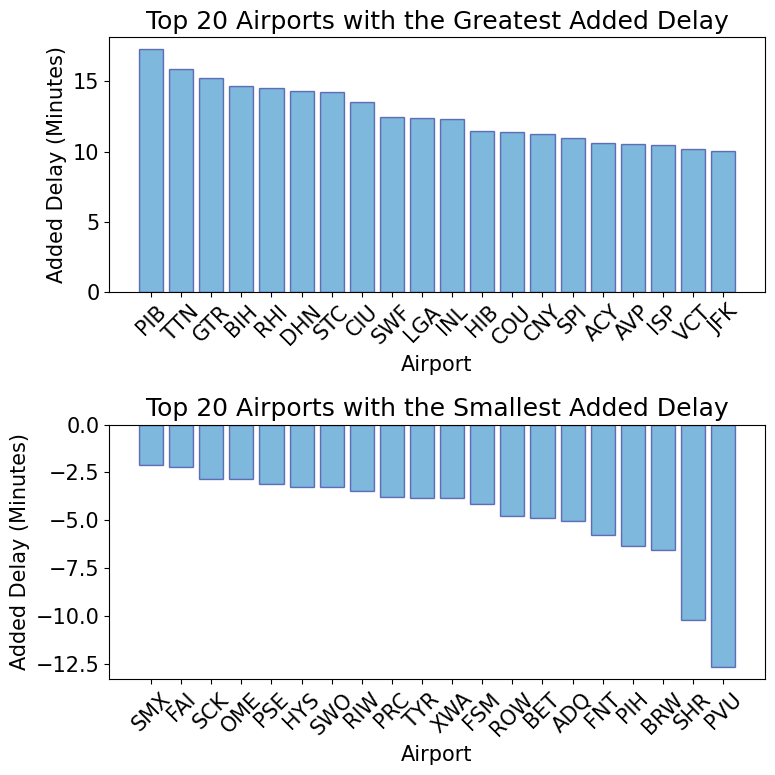

In [76]:
means_series = pd.Series(means)
# Sorting the series in descending order by value
sorted_means = means_series.sort_values(ascending=False)

plt.rcParams['font.family'] = 'sans'

# Selecting the top 20 entries
top_20_airports = sorted_means.head(20)
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(8, 8))  # Larger figure size for clarity
ax[0].bar(top_20_airports.index, top_20_airports, alpha=0.5, color="#0072BD", edgecolor='navy')  # Using a different color for distinction
ax[0].set_title('Top 20 Airports with the Greatest Added Delay')
ax[0].set_xlabel('Airport')
ax[0].set_ylabel('Added Delay (Minutes)')
ax[0].set_xticklabels(top_20_airports.index, rotation=45)# Rotate the labels to fit them nicely


top_20_airports = sorted_means.tail(20)
ax[1].bar(top_20_airports.index, top_20_airports, alpha=0.5, color="#0072BD", edgecolor='navy')  # Using a different color for distinction
ax[1].set_title('Top 20 Airports with the Smallest Added Delay')
ax[1].set_xlabel('Airport')
ax[1].set_ylabel('Added Delay (Minutes)')
ax[1].set_xticklabels(top_20_airports.index, rotation=45)# Rotate the labels to fit them nicely


plt.tight_layout()  # Adjust subplots
plt.show()

## Find which routes add the most/least time to a flights

In [108]:
# Create a new DataFrame from the stack of 'mean_flight', which aligns well with your requirements
stacked_df = mean_flight.stack().reset_index()
stacked_df['route'] = stacked_df['level_0'] + '->' + stacked_df['level_1']

# Rename columns, set the index, and sort by 'delay' in descending order
routes = (
    stacked_df.rename(columns={0: 'delay'})
    .set_index('route')
    .sort_values('delay', ascending=False)  # Sort from greatest to smallest
).drop(columns = ['level_0', 'level_1'])

[55.08360711 38.93724745 37.18724745 36.93724745 36.79439031 35.43724745
 35.30761782 34.26064415 33.06224745 32.56224745 31.84633836 31.66666667
 30.79310345 30.73973615 30.53225806 30.5        30.22891412 29.93724745
 29.93724745 29.48167163]


/var/folders/b2/z2q2350912181z4lh8p9jrc40000gn/T/ipykernel_26406/3376968961.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(top_20_airports.index, rotation=90)# Rotate the labels to fit them nicely
/var/folders/b2/z2q2350912181z4lh8p9jrc40000gn/T/ipykernel_26406/3376968961.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(top_20_airports.index, rotation=90)# Rotate the labels to fit them nicely


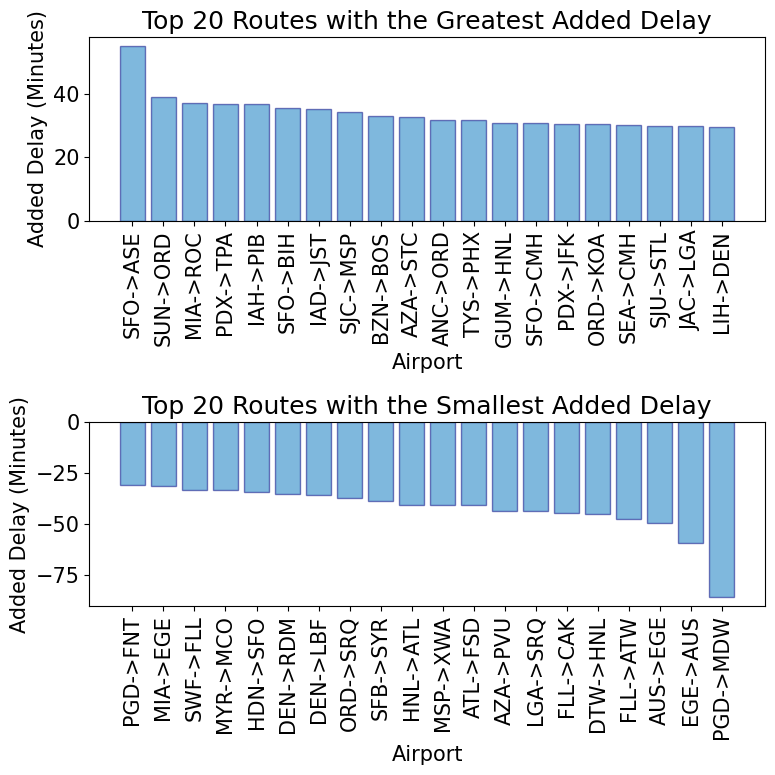

In [115]:

plt.rcParams['font.family'] = 'sans'

# Selecting the top 20 entries
top_20_airports = routes.head(20)
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(8, 8))  # Larger figure size for clarity
ax[0].bar(top_20_airports.index, top_20_airports.values.T[0], alpha=0.5, color="#0072BD", edgecolor='navy')  # Using a different color for distinction
ax[0].set_title('Top 20 Routes with the Greatest Added Delay')
ax[0].set_xlabel('Airport')
ax[0].set_ylabel('Added Delay (Minutes)')
ax[0].set_xticklabels(top_20_airports.index, rotation=90)# Rotate the labels to fit them nicely


top_20_airports = routes.tail(20)
ax[1].bar(top_20_airports.index, top_20_airports.values.T[0], alpha=0.5, color="#0072BD", edgecolor='navy')  # Using a different color for distinction
ax[1].set_title('Top 20 Routes with the Smallest Added Delay')
ax[1].set_xlabel('Airport')
ax[1].set_ylabel('Added Delay (Minutes)')
ax[1].set_xticklabels(top_20_airports.index, rotation=90)# Rotate the labels to fit them nicely


plt.tight_layout()  # Adjust subplots
plt.show()

## Simulatate a flight trajectory using a Monte Carlo Simulation

In [126]:
path = ["BOS", "JFK", "MIA"] # change the path here

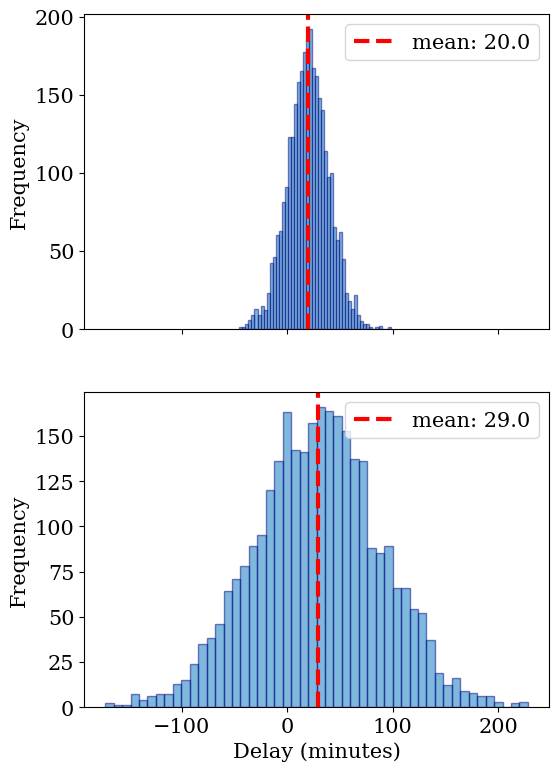

In [127]:
initial_state = 0
delay = distribution_delay(path, flights_df, first_df, functions, int(3e3), initial_state = initial_state)
delay2 = distribution_delay(path, flights_df, first_df, functions, int(3e3))
expected_delay = calculate_expected_delay(path, means, mean_arr, mean_flight)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15

path_label = path[0]
for i, airport in enumerate(path):
    if i != 0:
        path_label += ' -> ' + airport
# Plotting the histogram with a vertical line at the mean

fig, (ax0, ax1) = plt.subplots(2, 1, sharex = True, figsize=(6, 9))
ax0.hist(delay, bins=50, alpha=0.5, color="#0072BD", edgecolor='navy')
ax0.axvline(np.mean(delay), color='red', linestyle='dashed', linewidth=3, label=f"mean: {np.round(np.mean(delay))}")
ax0.set_ylabel('Frequency')
ax0.legend()
ax1.hist(delay2, bins=50, alpha=0.5, color=	"#0072BD", edgecolor='navy')
ax1.axvline(np.mean(delay2), color='red', linestyle='dashed', linewidth=3, label=f"mean: {np.round(np.mean(delay2))}")
ax1.set_xlabel('Delay (minutes)')
ax1.set_ylabel('Frequency')
ax1.legend()
plt.tight_layout
plt.show()

In [50]:
print("Mean delay on the ground": np.mean(np.array([x for x in ground if not np.isnan(x)]))

5.070214392943251

## Sandbox

In [ ]:
ground = []
for airport in airport_data.keys():
    ground.extend(airport_data[airport])
arr = np.array(ground)
ground_mean = np.mean(arr[~np.isnan(arr)])
print(ground_mean)

In [ ]:
flight_delays = (df.ARR_DELAY - df.DEP_DELAY).dropna()
_, p_value = ttest_1samp(flight_delays, - ground_mean)
print(f"{100 * (1 - p_value)}")

In [ ]:
destinations = df.DEST.unique()
origins = df.ORIGIN.unique()

days = df.DAY_OF_WEEK.unique()
M_days = {}
P_days = {}
day_name = {1: "MON",
            2: "TUE",
            3: "WED",
            4: "THU",
            5: "FRI",
            6: "SAT",
            7: "SUN"
           }
for day in days:
    day = day_name[day]
    M, P = get_m_p(df.loc[df.DAY_OF_WEEK==day], destinations, origins)
    M_days[day] = M
    P_days[day] = P
print(M_days)
print(P_days)

In [ ]:
U_M, Sigma_M, VT_M = np.linalg.svd(M)
U_P, Sigma_P, VT_P= np.linalg.svd(P)
U_P[:, 0] * Sigma_P[0] @ VT_P[0,:]

In [ ]:
destinations = df.DEST.unique()
origins = df.ORIGIN.unique()

get_influences(M)

In [ ]:
U_P

In [ ]:
tail_numbers = df.TAIL_NUM.unique()

for number in tail_numbers:
    flights = df[df.loc[:, "TAIL_NUM"] == tail_1.loc[:, ["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME"]]
    


df[df.loc[:, "TAIL_NUM"] == tail_1.loc[:, ["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_ARR_TIME"]]